<a href="https://colab.research.google.com/github/krheams60/Sales-predictions/blob/main/Project2_Part3_Ken_Rheams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import (ColumnTransformer, make_column_selector,
                             make_column_transformer)
from sklearn.metrics import (roc_auc_score, ConfusionMatrixDisplay,
                             PrecisionRecallDisplay, RocCurveDisplay,
                             f1_score, accuracy_score, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
# Load data
df = pd.read_csv('/content/archive.zip')
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [4]:
# Make copy 
eda_df = df.copy()

In [5]:
# Check for missing or erroneous data, there are no missing values
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [6]:
# Check for missing data and there is no missing data
eda_df.isna().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

In [7]:
# Check for duplicates
eda_df.duplicated().sum()

52

In [8]:
# drop duplicates
eda_df.drop_duplicates(inplace=True)

In [9]:
# duplicates dropped
eda_df.duplicated().sum()

0

In [10]:
# Dropped columns that has no revelance to finding income range
df = df.drop(columns=['fnlwgt', 'educational-num', 'relationship', 'workclass'])
df.head()


,age,education,marital-status,occupation,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,11th,Never-married,Machine-op-inspct,Black,Male,0,0,40,United-States,<=50K
1,38,HS-grad,Married-civ-spouse,Farming-fishing,White,Male,0,0,50,United-States,<=50K
2,28,Assoc-acdm,Married-civ-spouse,Protective-serv,White,Male,0,0,40,United-States,>50K
3,44,Some-college,Married-civ-spouse,Machine-op-inspct,Black,Male,7688,0,40,United-States,>50K
4,18,Some-college,Never-married,?,White,Female,0,0,30,United-States,<=50K


In [11]:
# value count of <=50K and >50K
df['income'].value_counts()

<=50K    37155
>50K     11687
Name: income, dtype: int64

In [12]:
# Replace income column with binary values
df['income'].replace({'<=50K':0, '>50K':1}, inplace=True)

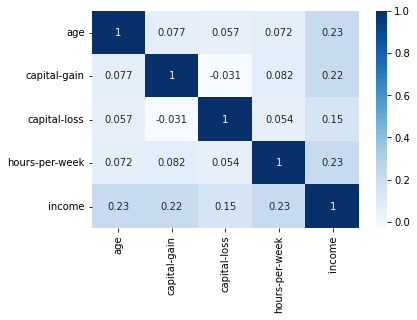

In [13]:
# This graph shows the correlation coefficients between features of the dataframe
corr = df.corr()
sns.heatmap(corr, cmap = 'Blues', annot = True);

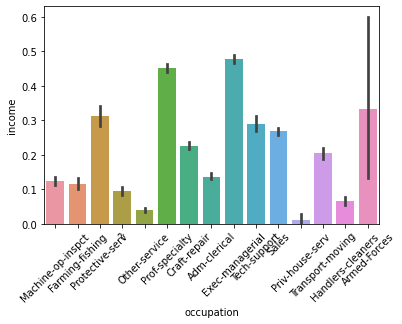

In [14]:
# This graph shows Adm-clerical and other-services having the highest percentage
# per the ratio of income
sns.barplot(data = df, x = 'occupation', y = 'income')
plt.xticks(rotation = 45);

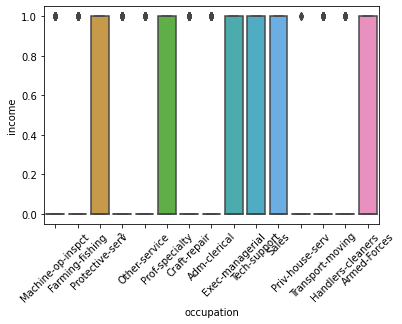

In [15]:
# This chart shows the features that have outliers 
sns.boxplot(x='occupation', y='income', data=df)
plt.xticks(rotation = 45);

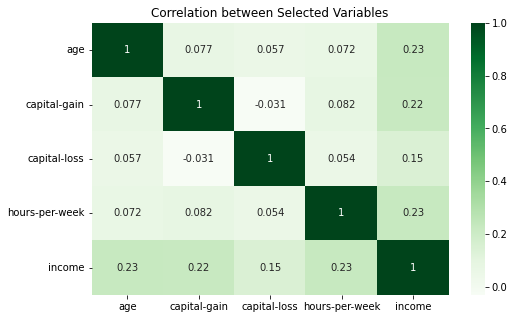

In [16]:
# The correlation coefficients between features of the dataframe
plt.figure(figsize=[8,5])
sns.heatmap(corr,annot=True,cmap='Greens')
plt.title("Correlation between Selected Variables")
plt.show()

 - This shows a weak correlation between income and the features
 

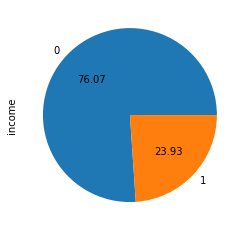

In [23]:
# Pie chart for income values
df['income'].value_counts().plot(kind="pie", autopct="%.2f")
plt.show()

 - This pie chart shows that 76.07% have less or equal to $50,000 and that
 - 23.93% have more than $50,000
 

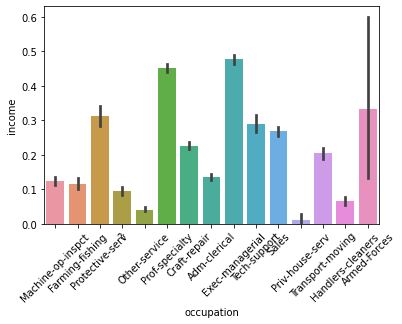

In [32]:
# The chart shows income percent per occupation
sns.barplot(data = df, x = 'occupation', y = 'income')
plt.xticks(rotation = 45);

 - The chart shows that Admin-clerical and other service has the highest 
 - percentage income while Protective serv and Tech support sales has the lowest
 